# Figure 1: linear stability

In [1]:
import sys
from math import cos, exp, pi, sin
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sb
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset
from numba import jit

sys.path.append("../code/")

import xgi
from hypersync_draw import *
from hypersync_generate import *
from hypersync_identify import *
from hypersync_integrate import *

sb.set_theme(style="ticks", context="paper")

results_dir = "../results/"
data_dir = "../data/"

Path(results_dir).mkdir(parents=True, exist_ok=True)
Path(data_dir).mkdir(parents=True, exist_ok=True)

## Spectrum

In [2]:
@jit
def lambda2(N, K1, K2, q, r):
    """
    Computes the lambda_max from Eq 5

    Parameters
    ----------
    N : int
        Number of nodes
    K1 : float
        Pairwise coupling strength
    K2 : float
        Triadic coupling strength
    q : int
        Winding number (number of twists of twisted state)
    r : int
        Coupling range (for ring structure)

    Returns
    -------
    lambda_2 : float
        Maximum non-zeros Lyapunov exponent
    """
    a2 = K1 * cos(2 * np.pi * q / N) / (2 * r)
    a3 = K1 * cos(4 * np.pi * q / N) / (2 * r)
    a1 = -2 * (a2 + a3)
    
    # sym
    #b2 = K2 * (1 + cos(2 * np.pi * q / N) + cos(6 * np.pi * q / N)) / (r * (2 * r - 1))
    #b3 = K2 * (1 + cos(2 * np.pi * q / N) + cos(6 * np.pi * q / N)) / (r * (2 * r - 1))
    
    # asym
    #b2 = K2 * (2 * cos(8 * np.pi * q / N) + + 2 - cos(10 * np.pi * q / N)) / (r * (2 * r - 1))
    #b3 = K2 * (cos(12 * np.pi * q / N) + 2 * cos(10 * np.pi * q / N) - 
    #           cos(8 * np.pi * q / N) + 2 * cos(6 * np.pi * q / N) - 1) / (r * (2 * r - 1))
    
    # sym SC
    b2 = 2 * K2 * (1 + cos(6 * np.pi * q / N)) / (r * (2 * r - 1))
    b3 = 2 * K2 * (cos(6 * np.pi * q / N)) / (r * (2 * r - 1))
    
    b1 = -2 * (b2 + b3)

    A1 = a1 + b1
    A2 = a2 + b2
    A3 = a3 + b3

    Lambda = np.zeros(N, dtype=np.complex_)
    for i in range(N):
        Lambda[i] = (
            A1
            + A2 * np.exp(2j * np.pi * i / N)
            + A3 * np.exp(2j * np.pi * i * 2 / N)
            + A2 * np.exp(2j * np.pi * i * (N - 1) / N)
            + A3 * np.exp(2j * np.pi * i * (N - 2) / N)
        )

    Lambda = np.real(Lambda)
    lambda_2 = np.sort(Lambda[1:])[-1]

    return lambda_2

/var/folders/wm/5gv37br900l73y63tjf8sr1r0000gn/T/ipykernel_85489/3732619864.py:2: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def lambda2(N, K1, K2, q, r):


/Users/maxime/.pyenv/versions/hypersync/lib/python3.9/site-packages/labellines/core.py:151: UserWarning: Tried to label line Line2D(_child5), but could not find a label for it.
  warnings.warn(


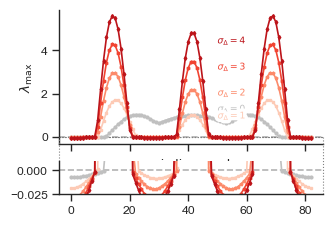

In [3]:
suf = "ring_sym_SC"
#suf = "ring_asym"

m = 5
N = 83
r = 2
r1 = 1
r2 = range(m)
Lambda_2 = np.zeros((N, m), dtype=np.complex_)

for q in range(N):
    for j in range(m):
        Lambda_2[q, j] = lambda2(N, r1, r2[j], q, r)

fig, (ax, axins1) = plt.subplots(
    2, 1, figsize=(3.4, 2.4), height_ratios=[4, 1], sharex=True
)

ax.set_xlabel(r"$q$, winding number")
ax.set_ylabel(r"$\lambda_\mathrm{max}$")

markers = ["o", "s", "p", "h", "d"]
labels = [rf"$\sigma_\Delta={i}$" for i in range(5)]
colors = ["silver"] + sb.color_palette("Reds", n_colors=len(labels) - 1)

for i in range(m):
    ax.plot(
        Lambda_2.real[:, i],
        linestyle="-",
        # linewidth=3,
        marker=markers[i],
        ms=2,
        color=colors[i],
        # alpha=0.6,
        label=labels[i],
    )

ax.axhline(0, linestyle="--", alpha=0.6, c="grey", zorder=-2)


from labellines import labelLine, labelLines

legs = labelLines(
    ax.get_lines(),
    zorder=2.5,
    xvals=[40] * 5,
    yoffsets=[0.3] + [0.05] * 5,
    fontsize="x-small",
    align=False,
)
x_offset = 15
for leg in legs:
    x, y = leg.get_position()
    leg.set_position((x + x_offset, y))


for i in range(m):
    axins1.plot(
        Lambda_2.real[:, i],
        linestyle="-",
        # linewidth=3,
        marker=markers[i],
        ms=2,
        color=colors[i],
        # alpha=0.6,
        label=labels[i],
    )

axins1.set_ylim(ymax=0.01, ymin=-0.025)
axins1.axhline(0, linestyle="--", alpha=0.6, c="grey", zorder=-2)
axins1.set_ylabel("")

mark_inset(ax, axins1, loc1=2, loc2=4, ec="0.5", ls=":")

sb.despine()

#plt.savefig("lambda2.pdf")

In [4]:
np.where(Lambda_2.real[:, 4] < 0 )

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8, 21, 22, 23, 24, 25, 26, 27, 28,
        29, 30, 31, 32, 33, 34, 35, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57,
        58, 59, 60, 61, 62, 75, 76, 77, 78, 79, 80, 81, 82]),)

In [5]:
np.where(Lambda_2.real[:, 0] < 0 )

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 72, 73, 74, 75, 76,
        77, 78, 79, 80, 81, 82]),)

## Fraction of stable states

In [6]:
m = 50
N1 = 83
N2 = 830
r = 2
k1 = 1
k2 = np.linspace(0, 10, num=m)

Lambda_2 = np.zeros((N1, m), dtype=np.complex_)
for q in range(N1):
    for j in range(m):
        Lambda_2[q, j] = lambda2(N1, k1, k2[j], q, r)
stable_fraction1 = np.mean(Lambda_2 < 0, axis=0)

Lambda_2 = np.zeros((N2, m), dtype=np.complex_)
for q in range(N2):
    for j in range(m):
        Lambda_2[q, j] = lambda2(N2, k1, k2[j], q, r)
stable_fraction2 = np.mean(Lambda_2 < 0, axis=0)

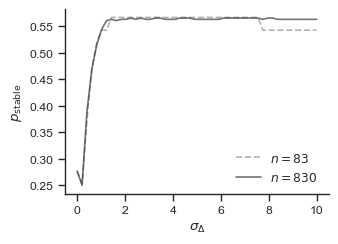

In [7]:
fig, ax = plt.subplots(figsize=(3.4, 2.4))

ax.set_xlabel(r"$\sigma_\Delta$")
ax.set_ylabel(r"$p_\mathrm{stable}$")


ax.plot(
    k2,
    stable_fraction1,
    linestyle="--",
    color="grey",
    alpha=0.6,
    label=r"$n=83$",
)
ax.plot(
    k2,
    stable_fraction2,
    linestyle="-",
    color="k",
    alpha=0.6,
    label=r"$n=830$",
)

# ax.set_xticks([0, 2, 4])
#ax.set_yticks([0.2, 0.5, 0.8])
#ax.set_ylim(ymin=0.18)


ax.legend(loc="lower right", frameon=False, ncol=1)

sb.despine()

#plt.savefig("stable_fraction.pdf")

## All together

/Users/maxime/.pyenv/versions/hypersync/lib/python3.9/site-packages/labellines/core.py:151: UserWarning: Tried to label line Line2D(_child5), but could not find a label for it.
  warnings.warn(


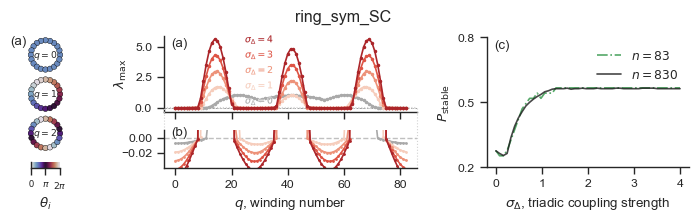

In [8]:
m = 5
N = 83
r = 2
r1 = 1
r2 = range(m)
Lambda_2 = np.zeros((N, m), dtype=np.complex_)

for q in range(N):
    for j in range(m):
        Lambda_2[q, j] = lambda2(N, r1, r2[j], q, r)

# figure setup
fig = plt.figure(figsize=(7, 2.1), layout="constrained")
subfigs = fig.subfigures(1, 3, wspace=0.05, width_ratios=[1, 3, 2.5])

ax1 = subfigs[0].subplots(1, 1)
(ax, axins1) = subfigs[1].subplots(2, 1, height_ratios=[2, 1], sharex=False)
ax2 = subfigs[2].subplots(1, 1)


markers = ["o", "s", "p", "h", "d"]
labels = [rf"$\sigma_\Delta={i}$" for i in range(5)]
colors = ["darkgrey"] + sb.color_palette("Reds", n_colors=len(labels) - 1, desat=0.8)

# plot full spectrum
#####################

for i in range(m):
    ax.plot(
        Lambda_2.real[:, i],
        linestyle="-",
        # linewidth=3,
        marker="o",  # "markers"[i],
        ms=1.5,
        color=colors[i],
        # alpha=0.6,
        label=labels[i],
    )

ax.axhline(0, linestyle="--", alpha=0.6, c="k", zorder=-2, lw=0.5)
ax.set_ylabel(r"$\lambda_\mathrm{max}$")


from labellines import labelLine, labelLines

legs = labelLines(
    ax.get_lines(),
    zorder=2.5,
    xvals=[15] * 5,
    yoffsets=[0.1] * 6,  # [0.3] + [0.05] * 5,
    fontsize="x-small",
    align=False,
    outline_width=0.5,
    clip_on=False,
)
x_offset = 15
for leg in legs:
    x, y = leg.get_position()
    leg.set_position((x + x_offset, y))


# plot zoom in
##############

for i in range(m):
    axins1.plot(
        Lambda_2.real[:, i],
        linestyle="-",
        # linewidth=3,
        marker="o",  # "markers"[i],
        ms=1,
        color=colors[i],
        # alpha=0.6,
        label=labels[i],
    )

axins1.set_ylim(ymax=0.01, ymin=-0.04)
axins1.axhline(0, linestyle="--", alpha=1, c="silver", zorder=-1, lw=1)
axins1.set_ylabel("")
axins1.set_xlabel(r"$q$, winding number")

mark_inset(ax, axins1, loc1=2, loc2=4, ec="lightgrey", ls=":")

# plot Porder
#############

m = 50
N1 = 83
N2 = 830
r = 2
r1 = 1
r2 = np.linspace(0, 4, num=m)

Lambda_2 = np.zeros((N1, m), dtype=np.complex_)
for q in range(N1):
    for j in range(m):
        Lambda_2[q, j] = lambda2(N1, r1, r2[j], q, r)
stable_fraction1 = np.mean(Lambda_2 < 0, axis=0)

Lambda_2 = np.zeros((N2, m), dtype=np.complex_)
for q in range(N2):
    for j in range(m):
        Lambda_2[q, j] = lambda2(N2, r1, r2[j], q, r)
stable_fraction2 = np.mean(Lambda_2 < 0, axis=0)


ax2.set_xlabel(r"$\sigma_\Delta$, triadic coupling strength")
ax2.set_ylabel(r"$P_\mathrm{stable}$")


ax2.plot(
    r2,
    stable_fraction1,
    linestyle="-.",
    color="g",
    # alpha=0.6,
    label=r"$n=83$",
    zorder=2
)
ax2.plot(
    r2,
    stable_fraction2,
    linestyle="-",
    color="k",
    alpha=0.8,
    label=r"$n=830$",
)

ax2.set_yticks([0.2, 0.5, 0.8])
#ax2.set_ylim(ymin=0.18)
axins1.set_yticks([0, -0.02])

ax.set_xticklabels([])

ax2.legend(loc="upper right", frameon=False, ncol=1)

# plot twisted states
#####################

N = 20

for q in range(3):
    psi = generate_q_twisted_state(N, q)
    H = xgi.trivial_hypergraph(N)

    pos = xgi.circular_layout(H, center=[0, -7.5 * q], radius=2.8)
    psi = psi % (2 * np.pi)
    _, im = xgi.draw_nodes(
        H,
        pos=pos,
        ax=ax1,
        node_fc=psi,
        vmin=0,
        vmax=2 * np.pi,
        node_fc_cmap="twilight",
        node_size=4,
        node_lw=0.3,
    )

    ax1.text(0, -7.5 * q, f"$q={q}$", fontsize="x-small", va="center", ha="center")


ax1.set_aspect("equal")

cbar = plt.colorbar(
    im,
    aspect=5,
    shrink=0.3,
    label=r"$\theta_i$",
    orientation="horizontal",
    location="bottom",
)
cbar.set_ticks(
    ticks=[0, np.pi, 2 * np.pi], labels=[0, r"$\pi$", r"$2\pi$"], fontsize="x-small"
)
cbar.outline.set_visible(False)

ax.text(0.03, 0.98, "(a)", transform=ax.transAxes, va="top", ha="left")
axins1.text(0.03, 1.1, "(b)", transform=axins1.transAxes, va="top", ha="left")
ax2.text(0.04, 0.98, "(c)", transform=ax2.transAxes, va="top", ha="left")
ax1.text(-0.5, 0.98, "(a)", transform=ax1.transAxes, va="top", ha="left")

fig.suptitle(suf)

sb.despine()

plt.savefig(f"../results/figure_1_v5_{suf}.pdf", dpi=250, bbox_inches="tight", pad_inches=0)

## Haromnics

In [9]:
data = np.load("../results/BS_SC_r/SC_x_r=2_xl.npy")

In [10]:
N = 83

In [11]:
k2s = np.arange(0, 3, 0.2)

In [12]:
data_reshaped = data.reshape((len(k2s), -1, 83))

In [13]:
data_reshaped.shape

(15, 100000, 83)

In [14]:
n_reps = 100000
from tqdm import tqdm

In [15]:
results = {}

thetas_arr = data_reshaped.swapaxes(0, 1)  # get (n_rep, k2s)
thetas_arr = thetas_arr[:, :, :, None]
for j, k2 in enumerate(tqdm(k2s)):
    states = [identify_state(thetas, atol=0.05) for thetas in thetas_arr[:, j]]
    states_unique, counts = np.unique(states, return_counts=True)
    probs = counts / n_reps

    results[k2] = {}
    for state, prob in zip(states_unique, probs):
        results[k2][state] = prob

 40%|██████████████████▍                           | 6/15 [00:51<01:16,  8.49s/it]/Users/maxime/.pyenv/versions/hypersync/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/maxime/.pyenv/versions/hypersync/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
100%|█████████████████████████████████████████████| 15/15 [02:14<00:00,  8.95s/it]


In [16]:
import pandas as pd

In [17]:
df = pd.DataFrame.from_dict(results, orient="index").reset_index(names="k2")
df = df.melt(id_vars="k2", var_name="state", value_name="proba")

In [18]:
df

,k2,state,proba
0,0.0,-1-twisted,0.23619
1,0.2,-1-twisted,0.24134
2,0.4,-1-twisted,0.24079
3,0.6,-1-twisted,0.24226
4,0.8,-1-twisted,0.23026
...,...,...,...
175,2.0,sync,0.00001
176,2.2,sync,NaN
177,2.4,sync,NaN
178,2.6,sync,NaN


In [19]:
df["q"] = df["state"].apply(lambda x: int(x[:-8]) if "twisted" in x else None)
df["k"] = df["state"].apply(lambda x: int(x[:-8]) if "cluster" in x else None)

#df["state"] = df["state"].replace("sync", "0-twisted")

df

,k2,state,proba,q,k
0,0.0,-1-twisted,0.23619,-1.0,None
1,0.2,-1-twisted,0.24134,-1.0,None
2,0.4,-1-twisted,0.24079,-1.0,None
3,0.6,-1-twisted,0.24226,-1.0,None
4,0.8,-1-twisted,0.23026,-1.0,None
...,...,...,...,...,...
175,2.0,sync,0.00001,NaN,None
176,2.2,sync,NaN,NaN,None
177,2.4,sync,NaN,NaN,None
178,2.6,sync,NaN,NaN,None


In [20]:
mask_pos = (df["q"] >= 0) + (df["q"].isna())
mask_nobig = (98 < df["q"]) + (df["q"] < 4) + (df["q"].isna())
mask_sync = (df["state"] != "sync") # very very small, and same as 0-twisted# to avoid having two points

In [21]:
df[mask_pos * mask_nobig * mask_sync].state.unique() 

array(['0-twisted', '1-twisted', '2-twisted', '3-twisted', 'other'],
      dtype=object)

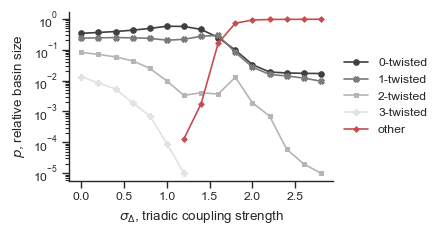

In [22]:
# labels = [f"{i}-twisted" for i in range(5)] + ["other"]
unique_states = sorted(
    [i for i in df[mask_pos * mask_nobig * mask_sync].state.unique() if "twisted" in i]
)
labels = unique_states + ["other"]

fig, ax = plt.subplots(figsize=(3.4, 2.2))
g = sb.lineplot(
    data=df[mask_pos * mask_nobig* mask_sync],
    x="k2",
    y="proba",
    hue="state",
    markers=True,
    ax=ax,
    # alpha=0.7,
    style="state",
    dashes=False,
    hue_order=labels,
    ms=4,
    mec=None,
    # mfc="w",
    palette=sb.color_palette("Greys_r", n_colors=len(unique_states)) + ["r"],
    legend=True,
)

g.set(yscale="log")

ax.set_xlabel(r"$\sigma_{\Delta}$, triadic coupling strength")
ax.set_ylabel("$p$, relative basin size")

sb.despine()
#ax.set_ylim(ymin=5e-4, ymax=1.2)

sb.move_legend(g, loc="center left", bbox_to_anchor=(1, 0.5), frameon=False, title="")

#ax.set_ylim(ymin=5e-4, ymax=1.2)


# plt.savefig(f"{results_dir}figure_2.pdf", dpi=250, bbox_inches="tight", pad_inches=0.03)
#plt.savefig(f"{results_dir}figure_2_{suf}.png", dpi=250, bbox_inches="tight", pad_inches=0.03)

In [23]:
from labellines import labelLine, labelLines


/Users/maxime/.pyenv/versions/hypersync/lib/python3.9/site-packages/labellines/core.py:151: UserWarning: Tried to label line Line2D(_child5), but could not find a label for it.
  warnings.warn(


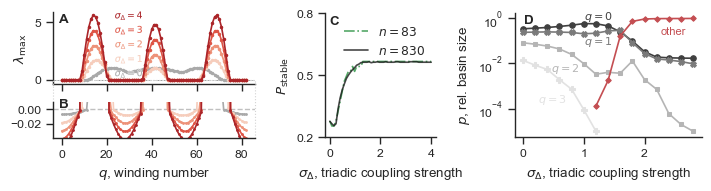

In [26]:
m = 5
N = 83
r = 2
r1 = 1
r2 = range(m)
Lambda_2 = np.zeros((N, m), dtype=np.complex_)

for q in range(N):
    for j in range(m):
        Lambda_2[q, j] = lambda2(N, r1, r2[j], q, r)

# figure setup
fig = plt.figure(figsize=(7, 1.8), layout="constrained")
subfigs = fig.subfigures(1, 3, wspace=0.05, width_ratios=[3, 2, 3])

ax1 = subfigs[2].subplots(1, 1)
(ax, axins1) = subfigs[0].subplots(2, 1, height_ratios=[2, 1], sharex=False)
ax2 = subfigs[1].subplots(1, 1)


markers = ["o", "s", "p", "h", "d"]
labels = [rf"$\sigma_\Delta={i}$" for i in range(5)]
colors = ["darkgrey"] + sb.color_palette("Reds", n_colors=len(labels) - 1, desat=0.8)

# plot full spectrum
#####################

for i in range(m):
    ax.plot(
        Lambda_2.real[:, i],
        linestyle="-",
        # linewidth=3,
        marker="o",  # "markers"[i],
        ms=1.5,
        color=colors[i],
        # alpha=0.6,
        label=labels[i],
    )

ax.axhline(0, linestyle="--", alpha=0.6, c="k", zorder=-2, lw=0.5)
ax.set_ylabel(r"$\lambda_\mathrm{max}$")


from labellines import labelLine, labelLines

legs = labelLines(
    ax.get_lines(),
    zorder=2.5,
    xvals=[15] * 5,
    yoffsets=[0.1] * 6,  # [0.3] + [0.05] * 5,
    fontsize="x-small",
    align=False,
    outline_width=0.5,
    clip_on=False,
)
x_offset = 15
for leg in legs:
    x, y = leg.get_position()
    leg.set_position((x + x_offset, y))


# plot zoom in
##############

for i in range(m):
    axins1.plot(
        Lambda_2.real[:, i],
        linestyle="-",
        # linewidth=3,
        marker="o",  # "markers"[i],
        ms=1,
        color=colors[i],
        # alpha=0.6,
        label=labels[i],
    )

axins1.set_ylim(ymax=0.01, ymin=-0.04)
axins1.axhline(0, linestyle="--", alpha=1, c="silver", zorder=-1, lw=1)
axins1.set_ylabel("")
axins1.set_xlabel(r"$q$, winding number")

mark_inset(ax, axins1, loc1=2, loc2=4, ec="lightgrey", ls=":")

# plot Porder
#############

m = 50
N1 = 83
N2 = 830
r = 2
r1 = 1
r2 = np.linspace(0, 4, num=m)

Lambda_2 = np.zeros((N1, m), dtype=np.complex_)
for q in range(N1):
    for j in range(m):
        Lambda_2[q, j] = lambda2(N1, r1, r2[j], q, r)
stable_fraction1 = np.mean(Lambda_2 < 0, axis=0)

Lambda_2 = np.zeros((N2, m), dtype=np.complex_)
for q in range(N2):
    for j in range(m):
        Lambda_2[q, j] = lambda2(N2, r1, r2[j], q, r)
stable_fraction2 = np.mean(Lambda_2 < 0, axis=0)


ax2.set_xlabel(r"$\sigma_\Delta$, triadic coupling strength")
ax2.set_ylabel(r"$P_\mathrm{stable}$")


ax2.plot(
    r2,
    stable_fraction1,
    linestyle="-.",
    color="g",
    # alpha=0.6,
    label=r"$n=83$",
    zorder=2,
)
ax2.plot(
    r2,
    stable_fraction2,
    linestyle="-",
    color="k",
    alpha=0.8,
    label=r"$n=830$",
)

ax2.set_yticks([0.2, 0.5, 0.8])
# ax2.set_ylim(ymin=0.18)
axins1.set_yticks([0, -0.02])

ax.set_xticklabels([])

ax2.legend(loc="upper right", frameon=False, ncol=1)

# plot twisted states
#####################

unique_states = sorted(
    [i for i in df[mask_pos * mask_nobig * mask_sync].state.unique() if "twisted" in i]
)
labels = unique_states + ["other"]

g = sb.lineplot(
    data=df[mask_pos * mask_nobig * mask_sync],
    x="k2",
    y="proba",
    hue="state",
    markers=True,
    ax=ax1,
    # alpha=0.7,
    style="state",
    dashes=False,
    hue_order=labels,
    ms=4,
    mec=None,
    # mfc="w",
    palette=sb.color_palette("Greys_r", n_colors=len(unique_states)) + ["r"],
    legend=True,
)

g.set(yscale="log")

ax1.set_xlabel(r"$\sigma_{\Delta}$, triadic coupling strength")
ax1.set_ylabel("$p$, rel. basin size")

# ax.set_ylim(ymin=5e-4, ymax=1.2)

# sb.move_legend(g, loc="center left", bbox_to_anchor=(1, 0.5), frameon=False, title="")
# xvals = [0.5, 0.5, 0.5, 0.5, 2.1]
# labelLines(ax1.get_lines(), align=False, xvals=xvals, color="k")

x_pos = [0.45, 0.45, 0.27, 0.2, 0.85]
y_pos = [0.97, 0.77, 0.55, 0.3, 0.85]

for i, label in enumerate(labels):
    colors = sb.color_palette("Greys_r", n_colors=len(unique_states)) + ["r"]
    labelss = [f"$q={label.split('-')[0]}$" if label != "other" else "other" for label in labels]
    ax1.text(
        x_pos[i],
        y_pos[i],
        f"{labelss[i]}",
        color=colors[i],
        ha="center",
        va="center",
        transform=ax1.transAxes,
        fontsize="small"
    )

g.legend_.remove()


ax.text(0.03, 0.98, "A", transform=ax.transAxes, va="top", ha="left", weight="bold")
axins1.text(0.03, 1.1, "B", transform=axins1.transAxes, va="top", ha="left", weight="bold")
ax2.text(0.04, 0.98, "C", transform=ax2.transAxes, va="top", ha="left", weight="bold")
ax1.text(0.05, 0.99, "D", transform=ax1.transAxes, va="top", ha="left", weight="bold")

#fig.suptitle(suf)

sb.despine()

plt.savefig(f"../results/figure_S6_ringSC.pdf", dpi=250, bbox_inches="tight", pad_inches=0.05)